<a href="https://colab.research.google.com/github/Vince4513/Projet_ingenieur/blob/master/adsorption_without_class_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/3 - 5A/PROJET INGENIEUR/PINN_PDE/")

!pip install deepxde
!pip install --upgrade gspread==3.6.0

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Set the default float type to float64
Compiling model...
Building feed-forward neural network...
'build' took 0.063520 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.851240 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.47e+03, 1.27e+01, 1.73e-02, 2.37e-05, 1.47e+01, 1.50e-04]    [1.47e+03, 1.27e+01, 1.73e-02, 2.37e-05, 1.47e+01, 1.50e-04]    []  
10        [1.62e+02, 7.70e-01, 1.96e-03, 1.03e-01, 8.19e+00, 4.71e-03]    [1.62e+02, 7.70e-01, 1.96e-03, 1.03e-01, 8.19e+00, 4.71e-03]    []  

Best model at step 10:
  train loss: 1.71e+02
  test loss: 1.71e+02
  test metric: []

'train' took 31.748239 s

Saving loss history to /content/drive/MyDrive/3 - 5A/PROJET INGENIEUR/PINN_PDE/loss.dat ...
Saving training data to /content/drive/MyDrive/3 - 5A/PROJET INGENIEUR/PINN_PDE/train.dat ...
Saving test data to /content/drive/MyDrive/3 - 5A/PROJET INGENIEUR/PINN_PDE/test.dat ...


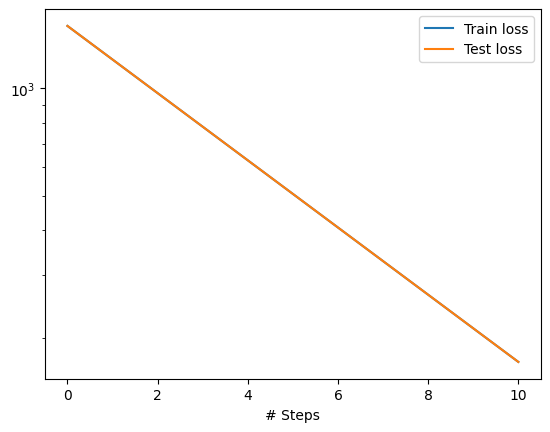

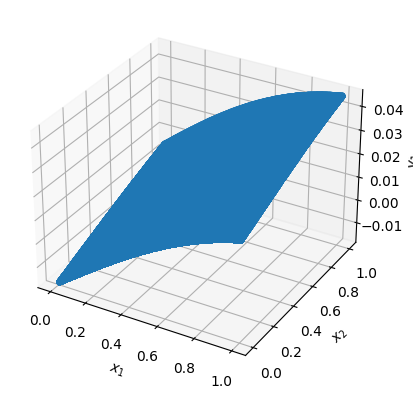

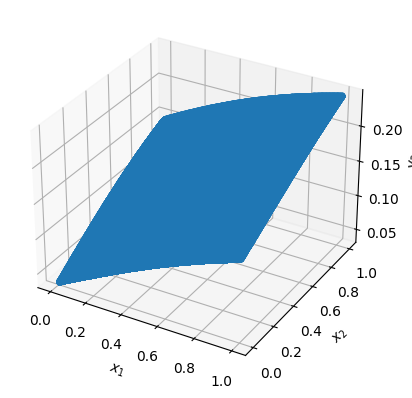

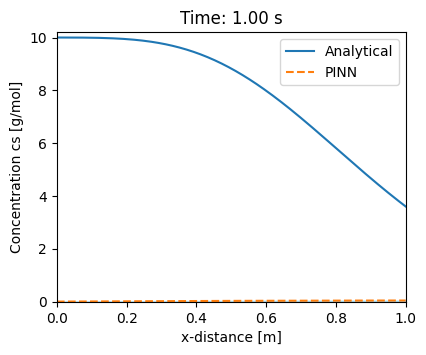

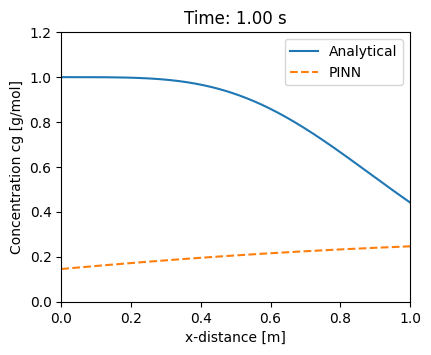

In [3]:
# -----------------------------------------------------------------------
# Importation des bibliothèques
# -----------------------------------------------------------------------
import gspread
import numpy as np
import pandas as pd
import deepxde as dde
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio.v2 as imageio
from io import BytesIO

# Configuration de la graine et du type de float
dde.config.set_random_seed(48)
dde.config.set_default_float('float64')

ug = 0.01                      #Vitesse spécifique de gaz
epsb = 0.5                     #Porosité du lit
kg = 0.0001                    #Coefficient de transfert
Ke = 10.0                      #Coefficient d'équilibre
dp = 0.005                     #Diamètre de particule
as_ = 6*(1-epsb)/dp            #Surface spécifique, dépend du diamètre de la sphère

x_start = 0
x_end = 1
time_start = 0
time_end = 1

total_points = 200
num_time_steps = 100
save_path = ""

iterations = 10

# Fonction lançant l'apprentissage et la prediction
# Résultat:
# cs: concentration prédite
# cg: concentration prédite
# loss_history, train_state: les résultats du modèle
# input, output: entrées et sorties du PINN
now = datetime.today()
datetime_ = f"{now.year}_{now.month}_{now.day}_{now.hour}_{now.minute}_{now.second}"

# Preparation of Input for Prediction using PINN -------------------------------
x = np.linspace(x_start, x_end, total_points)
t = np.linspace(time_start, time_end, num_time_steps)
X, T = np.meshgrid(x,t)
input = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Fonction créant les équations différentielles partielles --------------------------
def pde(z, u):
  #z is a 2D array where z[:,0:1] represents spatial domain in z direction and z[:,1:2] represents the temporal domain
  #z is the input of the neural net
  #u is a 2D array where u[:,0:1] represents water depth and u[:,1:2] represents the water velocity
  #u is the output of the neural net

  cs, cg = u[:, 0:1], u[:, 1:]

  dcs_dt = dde.grad.jacobian(u, z, i=0, j=1)
  dcg_dz = dde.grad.jacobian(u, z, i=1, j=0)
  dcg_dt = dde.grad.jacobian(u, z, i=1, j=1)

  # eq1 = (dcg_dt + ug * dcg_dz) + (kg*as_/epsb) * (cg-cs/Ke)
  # eq2 = dcs_dt - (kg*as_/(1-epsb)) * (cg-cs/Ke)
  eq1 = (dcg_dt + ug * dcg_dz) + (kg*as_/epsb) * (10*cg - cs)/10
  eq2 = dcs_dt - (kg*as_/(1-epsb)) * (10*cg - cs)/10

  return [eq1, eq2]

# function for  Initial condition of water depth ------------------------------
def boundary_l(x,on_boundary):
  return on_boundary  and np.isclose(x[0], x_start)  # définit le boundary x=0, left

def boundary_r(x,on_boundary):
  return on_boundary  and np.isclose(x[0], x_end)  # définit le boundary x=L, right


geom = dde.geometry.Interval(x_start, x_end)
timedomain = dde.geometry.TimeDomain(time_start, time_end)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

#Define initial condition and boundary condition --------------------------
ic_cs = dde.icbc.IC(
  geomtime, lambda x: 0, lambda _, on_initial: on_initial, component=0
)
ic_cg = dde.icbc.IC(
  geomtime, lambda x: 0, lambda _, on_initial: on_initial, component=1
)
bc_cg = dde.icbc.DirichletBC(
  geomtime, lambda x: 1, boundary_l, component=1
) # C_g(0,t)=1
bc_dcg = dde.icbc.OperatorBC(
  geomtime, lambda x, y, _ : dde.grad.jacobian(y, x, i=0, j=1), boundary_r
) # dc_g/dz(L,t)=0

# Anchors of both concentrations ---------------------------------------
# observe_cs = dde.icbc.PointSetBC(
#     np.array([[0.0, 0.3, 0.5, 0.8, 0.0, 0.3, 0.5, 0.8, 0.0, 0.3, 0.5, 0.8, 0.0, 0.3, 0.5, 0.8],
#               [0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 1.0, 1.0, 1.0, 1.0]]).T,
#     np.array([[10.0, 8.0, 6.0, 5.0, 9.0, 7.5, 6.0, 5.0, 9.0, 7.0, 6.0, 4.0, 9.0, 7.0, 5.0, 3.0],
#               [0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 1.0, 1.0, 1.0, 1.0]]).T, component=0)
# observe_cg = dde.icbc.PointSetBC(
#     np.array([[0.0, 0.3, 0.5, 0.8, 0.0, 0.3, 0.5, 0.8, 0.0, 0.3, 0.5, 0.8, 0.0, 0.3, 0.5, 0.8],
#               [0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 1.0, 1.0, 1.0, 1.0]]).T,
#     np.array([[1.0, 0.6, 0.5, 0.4, 1.0, 0.6, 0.5, 0.4, 0.8, 0.6, 0.5, 0.4, 0.8, 0.5, 0.4, 0.3],
#               [0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 1.0, 1.0, 1.0, 1.0]]).T, component=1)

data = dde.data.TimePDE(
  geomtime, pde, [ic_cs, ic_cg, bc_cg, bc_dcg],
  num_domain=350000,
  num_boundary=3000,
  num_initial=30000,
  anchors=input
)

layer_size = [2] + [60] * 4 + [2]
net = dde.nn.FNN(layer_size, "tanh", "Glorot normal")
model = dde.Model(data, net)

# Adam --------------------------------------------------------------------------
model.compile("adam", lr=5e-4, loss_weights = [1e4, 1e4, 1e1, 1e1, 1e1, 1e1])
# pde_resampler = dde.callbacks.PDEPointResampler(period=10)
losshistory, train_state = model.train(iterations= iterations) # , callbacks=[pde_resampler]
dde.saveplot(losshistory, train_state, issave=True)
# Save the trained model
model.save(f"{save_path}Run_{datetime_}/1stStageAdamOptimized.h5")

# LBFGS --------------------------------------------------------------------------
# dde.optimizers.set_LBFGS_options(maxiter= 100, gtol= 1e-5)
# model.compile("L-BFGS", loss_weights = [1e2, 1e2, 1e5, 1e5, 1e4, 1e4])
# losshistory, train_state = model.train(callbacks=[pde_resampler])
# dde.saveplot(losshistory, train_state, issave=True)
# # Save the trained model
# model.save(f"{save_path}Run_{datetime_}/2ndStage_LBFGS_Optimzed.h5")

### Post Processing ------------------------------------------------------------
output = model.predict(input) #passing the input gridpoints and timestamps through optimized neural network

# Extracting concentration 'cs' and concentration 'cg' from the result ------------------
cs = (output[:, 0].reshape((-1, total_points)).T)
cg = (output[:, 1].reshape((-1, total_points)).T)

np.save(f"{save_path}Run_{datetime_}/cs.npy", cs)
np.save(f"{save_path}Run_{datetime_}/cg.npy", cg)


# Graphs -----------------------------------------------------------------------
# Functions
def mean_squared_error(predicted_values, true_values):
    """
    Calculate the mean squared error between predicted and true values.

    Parameters:
    - predicted_values: numpy array, predicted concentrations from the neural network.
    - true_values: numpy array, true concentrations from analytical solutions.

    Returns:
    - mse: float, mean squared error.
    """
    mse = np.mean((predicted_values - true_values)**2)
    rmse = np.sqrt(mse)
    return rmse


# cs = np.load('Run_{datetime_}/cs.npy')
# cg = np.load('Run_{datetime_}//cg.npy')

cs_analytical = pd.read_csv('cs_analytical.csv', header=None)
cg_analytical = pd.read_csv('cg_analytical.csv', header=None)

# Convert DataFrame to arrays
cs_analytical = cs_analytical.values
cg_analytical = cg_analytical.values

rmse_cs = mean_squared_error(cs, cs_analytical)
rmse_cg = mean_squared_error(cg, cg_analytical)


dt = time_end / num_time_steps
x = np.linspace(x_start, x_end, total_points)
t = np.linspace(time_start, time_end, num_time_steps)
X, T = np.meshgrid(x,t)
input = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))


### Post Processing
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(4.5, 3.5))

# Create a list to store the generated frames
frames = []

# Loop through each timestep
for timestep in range(cs.shape[1]):
    # Clear the axis
    ax.clear()

    # Plot the water depth at the current timestep

    ax.plot(x, cs_analytical[:, timestep], label='Analytical')
    ax.plot(x, cs[:, timestep], linestyle='--', label='PINN')

    # Fill the area between the curves
    ax.fill_between(x, 0, cs[:, timestep], color='skyblue', alpha=0.5)
   # ax.fill_between(x, 0, h_values_transpose[:, timestep], color='lightgreen', alpha=0.5)

    timestamp = (timestep+1) * dt
    # Set the axis labels and title
    ax.set_xlabel('x-distance [m]')
    ax.set_ylabel('Concentration cs [g/mol]')
    ax.set_title(f'Time: {timestamp:.2f} s')
    ax.set_xlim([x_start, x_end])
    ax.set_ylim([0, 10.2])
    ax.legend()  # Add legend

    # Create an in-memory file object
    img_buffer = BytesIO()

    # Save the current figure to the in-memory file object
    plt.savefig(img_buffer, format='png')

    # Read the contents of the in-memory file object and add it to the list of frames
    img_buffer.seek(0)
    img_data = img_buffer.getvalue()
    img = imageio.imread(img_data, format='PNG')
    frames.append(img)

    # Clear the in-memory file object for the next iteration
    img_buffer.close()

# Save the list of frames as an MP4 file
# (adjust the file name and parameters as needed)
mp4_filename = f'Run_{datetime_}/cs_animation.mp4'
imageio.mimsave(mp4_filename, frames, fps=10)

# Show the final animation
plt.show()


#Plot for velocity

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(4.5, 3.5))

# Create a list to store the generated frames
frames = []

# Loop through each timestep
for timestep in range(cg.shape[1]):
    # Clear the axis
    ax.clear()

    # Plot the water depth at the current timestep

    ax.plot(x, cg_analytical[:, timestep], label='Analytical')
    ax.plot(x, cg[:, timestep], linestyle='--', label='PINN')

    timestamp = (timestep+1) * dt
    # Set the axis labels and title
    ax.set_xlabel('x-distance [m]')
    ax.set_ylabel('Concentration cg [g/mol]')
    ax.set_title(f'Time: {timestamp:.2f} s')
    ax.set_xlim([x_start, x_end])
    #ax.set_ylim([0.8*np.min(u_analytical), 1.2*np.max(u_analytical)])
    ax.set_ylim([0, 1.2])
    ax.legend()  # Add legend

    # Create an in-memory file object
    img_buffer = BytesIO()

    # Save the current figure to the in-memory file object
    plt.savefig(img_buffer, format='png')

    # Read the contents of the in-memory file object and add it to the list of frames
    img_buffer.seek(0)
    img_data = img_buffer.getvalue()
    img = imageio.imread(img_data, format='PNG')
    frames.append(img)

    # Clear the in-memory file object for the next iteration
    img_buffer.close()

# Save the list of frames as an MP4 file
# (adjust the file name and parameters as needed)
mp4_filename = f'Run_{datetime_}/cg_animation.mp4'
imageio.mimsave(mp4_filename, frames, fps=10)

# Show the final animation
plt.show()